# Visual Question Answering for Adaptive Yielding Response Engine (AYRE)

In [2]:
# entire code is being run on an Ubuntu kernel. 
# not many QoL libraries are needed.
# your mileage may vary.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import requests

# dataset imports
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
# from torchvision.transforms import ToTensor, Resize, ToPILImage, Lambda
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize

# AI imports
from segmentation import UNet # importing the segmentation model
from transformers import ViltProcessor, ViltForQuestionAnswering
from torch.nn import functional as F
from torchvision.utils import make_grid
import torch


# statistics
from torchinfo import summary
import torchmetrics as TM

# test if GPU acceleration is working
torch.cuda.is_available()

True

### We will start by importing the segmentation model and doing a little test on it

In [3]:
# first step here is to load the segmentation model that will be used for inference moving forward.
PATH_TO_MODEL = "../semantic-segmentation/models/model_20231116-134707-checkpoint_14_02.pth"
segmodel = UNet(in_channels=3, out_channels=151)
segmodel.load_state_dict(torch.load(PATH_TO_MODEL)[0])
segmodel.eval()

UNet(
  (ups): ModuleList(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3):

In [4]:
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()

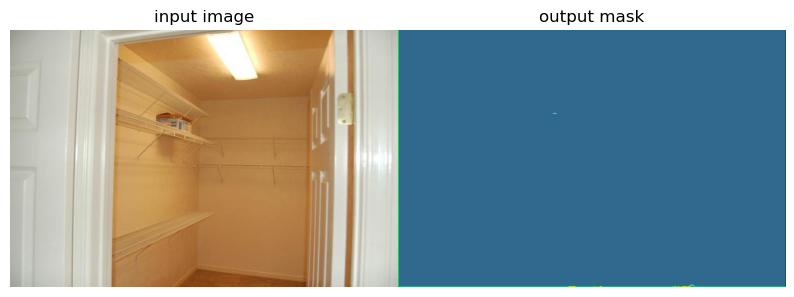

In [5]:
with torch.inference_mode():
    test_image = f"../semantic-segmentation/ade20k/ADEChallengeData2016/images/training/ADE_train_{np.random.randint(1, 10000):08d}.jpg"
    test_image = read_image(test_image)
    lmao = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
    test_image = lmao(test_image)[None, :, :, :]
    test_seg = segmodel(test_image)
    test_seg = test_seg.argmin(dim=1)
    test_seg = test_seg.unsqueeze(1)
    close_figures()

    fig = plt.figure(figsize=(10, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(make_grid(test_image[0].permute(1, 2, 0)))
    plt.title("input image")
    plt.axis("off")
    fig.add_subplot(1, 2, 2)
    plt.imshow(make_grid(test_seg[0].permute(1, 2, 0)))
    plt.title("output mask")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")

for fun, we will look at the classes idx's (might import the csv file here later)

In [6]:
test_seg.unique()

tensor([ 10,  32,  33,  47,  70,  82, 100, 106, 115, 118])

## Visual Question Answering: Loading in the dataset

#### NOTE: Due to a lot of system limitations, i will not be able to fine-tune the model at all. For now, we can test the vqa model by downloading an existing VQA model and passing in the segmentation as the attention mask. If this is better than it's base-case, then this proves to be a good proof of concept.

In [11]:
# prepare image + question
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "How many cats are there?"

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
vqamodel = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
trns = transforms.Compose([transforms.Resize((384, 512)), transforms.ToTensor()])
with torch.no_grad(), torch.autocast("cuda"):
    segmask = segmodel(trns(image).unsqueeze(0)).argmin(dim=1) / 151
    
# prepare inputs
encoding = processor(image, text, return_tensors="pt")
encoding['pixel_mask'] = segmask + 1

# forward pass
outputs = vqamodel(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", vqamodel.config.id2label[idx])
print(image.size)
encoding['pixel_mask'].shape, segmask.shape

Predicted answer: 2
(640, 480)


(torch.Size([1, 384, 512]), torch.Size([1, 384, 512]))

(-0.5, 511.5, 383.5, -0.5)

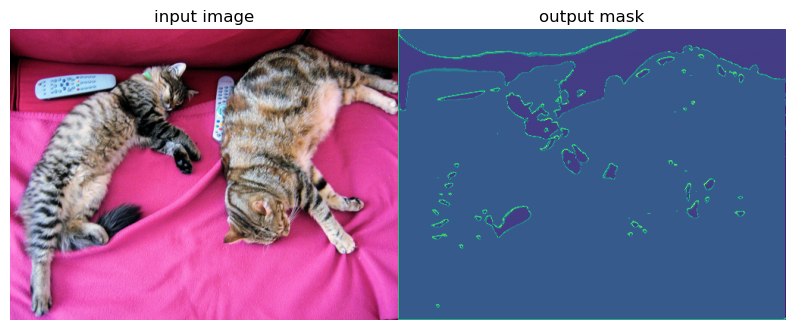

In [12]:
fig = plt.figure(figsize=(10, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(make_grid(trns(image)).permute(1, 2, 0))
plt.title("input image")
plt.axis("off")
fig.add_subplot(1, 2, 2)
plt.imshow(make_grid(segmask.permute(1, 2, 0)))
plt.title("output mask")
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")